In [1]:
import matplotlib
import numpy as np
import pysptk
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import librosa.display
import seaborn

WAV = "sm04010105105"

In [2]:
seaborn.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16,5)

### Plotting utility

In [3]:
def pplot(sp, envelope, title="no title"):
    plt.figure()
    plt.plot(sp, "b-", linewidth=2.0, label="Original log spectrum 20log|X(w)|")
    plt.plot(20.0/np.log(10)*envelope, "r-", linewidth=3.0, label=title)
    plt.xlim(0, len(sp))
    plt.xlabel("frequency bin")
    plt.ylabel("log amplitude")
    plt.legend(prop={'size': 20})

## Load audio file

In [4]:
fs, x = wavfile.read("./wav/"+WAV+".wav") 
# fs = sample rate ili frequency sample iz učitanog wava = 16 000 Hz
assert fs == 16000 
x = x.astype(np.float64) 

print(x.shape) 

(45986,)


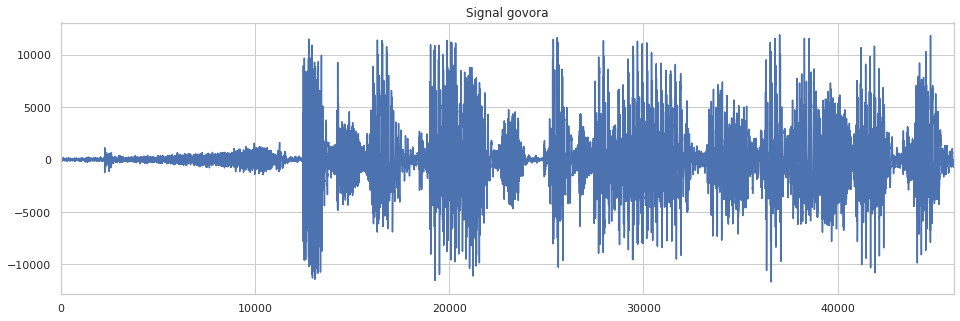

In [5]:
plt.plot(x)
plt.xlim(0, len(x))


plt.title("Signal govora")

Audio(x, rate=fs) #create an audio object, rate = sampling rate of the raw data (required when data param is being used as an array)

plt.savefig("./images/"+WAV+"/"+WAV+"_signalGovora.png")

## Windowing (Okvir)

Širina prozora = 1024

Blackmannov okvir - gdje se za koeficijente alpha koriste vrijednosti: 0.42, 0.5 i 0.08

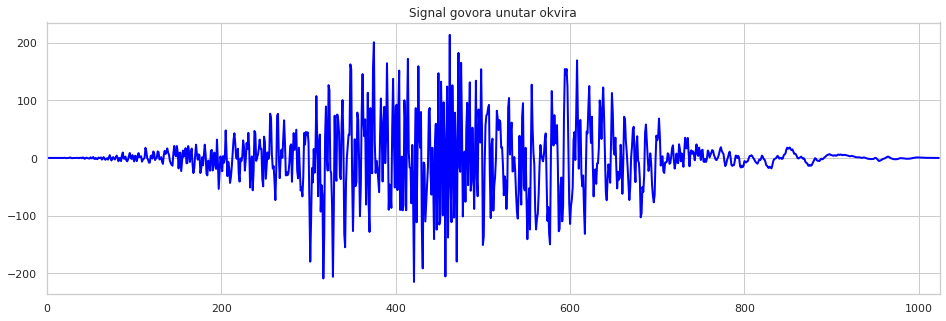

In [6]:
pos = 40000 
frame_length = 1024 # dužina frame-a, u broju uzorka
hop_length = 80 # 5 ms for 16kHz data - number of steps to advance between frames

frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
frames *= pysptk.blackman(frame_length)

assert frames.shape[1] == frame_length 

plt.plot(frames[int(pos/hop_length)], linewidth = 2.0, color='blue')
plt.xlim(0, frame_length)
plt.title("Signal govora unutar okvira")

plt.savefig("./images/"+WAV+"/"+WAV+"_signalGovoraOkvir.png")

## Source excitation - Pobuđivanje

Pobuda je niz impulsa ili šum.

Hop size = frame period in sample

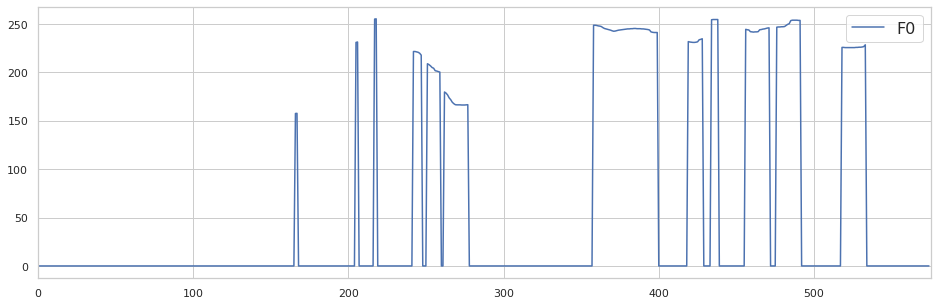

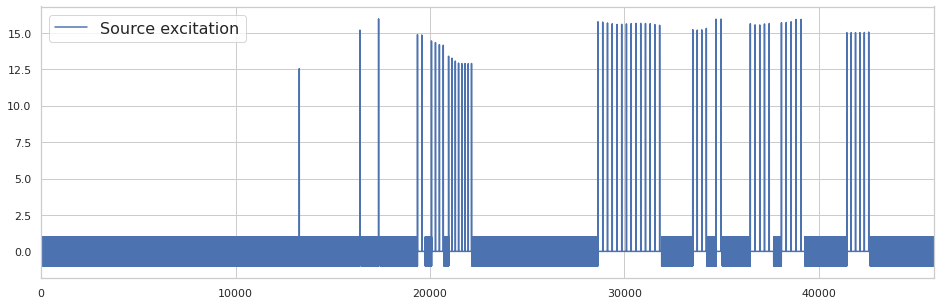

In [7]:
pitch = pysptk.swipe(x, fs=fs, hopsize=hop_length, min=60, max=250, otype="pitch")
# swipe - a saw-tooth waveform inspired pitch estimation

source_excitation = pysptk.excite(pitch, hop_length) 

f0 = pysptk.swipe(x, fs=fs, hopsize=hop_length, min=60, max=900, otype="f0") # f0 da dobijemo frekvenciju

plt.figure()
plt.plot(pitch, label="F0")
plt.xlim(0, len(pitch))
plt.legend(prop={'size': 16});
plt.savefig("./images/"+WAV+"/"+WAV+"_pitch.png")

plt.figure()
plt.plot(source_excitation, label="Source excitation")
plt.xlim(0, len(source_excitation))

plt.legend(prop={'size': 16});
plt.savefig("./images/"+WAV+"/"+WAV+"_sourceExcitation.png")



## Synthesis from mel-cepstrum

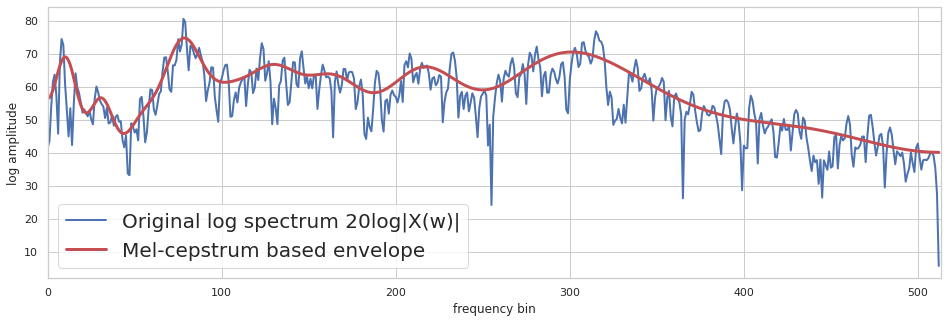

In [8]:
order = 25 # defaultna vrijednost za order mel-cepstruma
alpha = 0.42 

# izračun spectruma 20log|X(w)| za okvir 
sp = 20*np.log10(np.abs(np.fft.rfft(frames[int(pos/hop_length)])))

mgc = pysptk.mcep(frames[int(pos/hop_length)], order, alpha)
pplot(sp, pysptk.mgc2sp(mgc, alpha, 0.0, frame_length).real, title="Mel-cepstrum based envelope")
# sa .real se uzima samo realni dio kompleksnog broja

plt.savefig("./images/"+WAV+"/"+WAV+"_melCepstrumEnvelope.png")

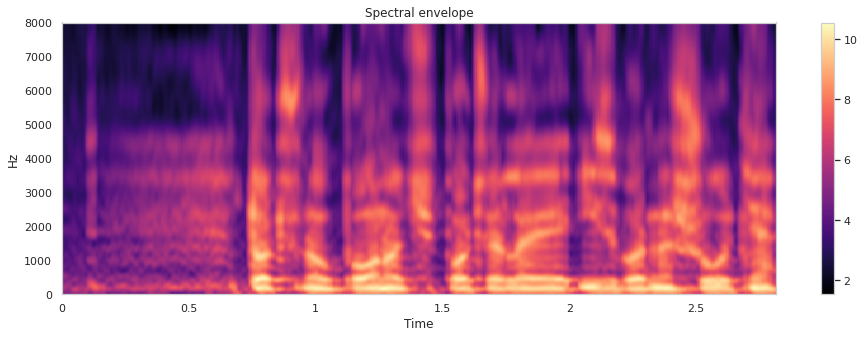

In [9]:
mc = pysptk.mcep(frames, order, alpha)
# mcep - mel-cepstrum analysis
# params - windowed frame, order of mel-cepstrum (default 25), alpha - all pass constant (default 0.35)

logH = pysptk.mgc2sp(mc, alpha, 0.0, frame_length).real
# mgc2sp - mel-generalized capstrum transform
# params - mel-generalized capstrum, all-pass constant, gamma, FFT length
# return - complex spectrum log_e(H(w))

librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
# specshow - display a spectogram
# params - matrix to display, sample rate, hop length, range for x and y axes

plt.colorbar()
plt.title("Spectral envelope");

plt.savefig("./images/"+WAV+"/"+WAV+"_spectralEnvelope.png")

## Source excitation generation

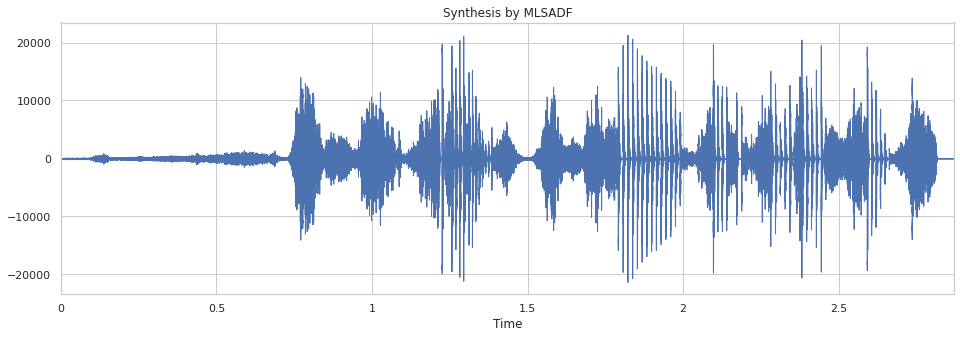

In [10]:
from pysptk.synthesis import MLSADF, Synthesizer

# Convert mel-cepstrum to MLSADF coefficients - "mel log spectrum approximation digital filter" that wraps mlsadf

b = pysptk.mc2b(mc, alpha)
# mc2b - mel-cepstrum to MLSA filter coefficients
# return - MLSA filter coefficients

synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), hop_length)
# synthesizer - speech waveform 
# params - a speech synthesis filter, hop size
# filter = MLSADF - MLSA digital filter that wraps mlsadf - params order of pade approximation (default = 4), all-pass constant

x_synthesized = synthesizer.synthesis(source_excitation, b)
# synthesis - synthesize a waveform given a source excitation and sequence of filter coefficients (e.g. cepstrum)
# params - source excitation, filter coefficients
# return - synthesized waveform

wavfile.write("./wav_mlsa/"+WAV+"_mlsa.wav", fs, x_synthesized.astype(np.int16))

librosa.display.waveplot(x_synthesized, sr = fs)
plt.title("Synthesis by MLSADF")

plt.savefig("./images/"+WAV+"/"+WAV+"_synthesisMLSA.png")

Audio(x_synthesized, rate=fs)

# Zvučni efekti

In [11]:
def zvucniEfekt(promjenaPitcha, promjenaBrzine, order=25, alpha=0.42):
    pitch = pysptk.swipe(x, fs=fs, hopsize=hop_length, min=60, max=250, otype="pitch")
    pitch *= promjenaPitcha

    source_excitation = pysptk.excite(pitch, int(hop_length*promjenaBrzine))
    
    mc = pysptk.mcep(frames, order, alpha)
    b = pysptk.mc2b(mc, alpha)
    
    synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), int(hop_length*promjenaBrzine))
    x_synthesized = synthesizer.synthesis(source_excitation, b)
    
    return Audio(x_synthesized, rate=fs)

### Bez efekta

In [12]:
zvucniEfekt(1,1)

### Smanjen pitch

In [13]:
zvucniEfekt(2,1)
wavfile.write("./wav_mod/"+WAV+"_modLowPitch.wav", fs, x_synthesized.astype(np.int16))

### Povećan pitch

In [14]:
zvucniEfekt(0.4,1)
wavfile.write("./wav_mod/"+WAV+"_modHighPitch.wav", fs, x_synthesized.astype(np.int16))

### Ubrazno

In [15]:
zvucniEfekt(1,0.8)
wavfile.write("./wav_mod/"+WAV+"_modAccelerated.wav", fs, x_synthesized.astype(np.int16))

### Usporeno

In [16]:
zvucniEfekt(1,1.3)
wavfile.write("./wav_mod/"+WAV+"_modSlowed.wav", fs, x_synthesized.astype(np.int16))